### Import

In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import optuna
import matplotlib.pyplot as plt
import datetime

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [3]:
dtypes = {
    'defaultPaymentMethod': str,
    'mode': str,
    'serviceClassificationName': str,
    'state': str,
    'address_county': str,
    'address_district': str,
    'discount_type': str,
    'subtotal': float,
    'travelingExpense': float,
    'discountNum': float,
    'isServicePackageBooking': float
}

In [4]:

df_main = pd.read_csv(
    r'C:\Users\USER\OneDrive\Documents\DSC_Project\20250517_資料集\一般訂單\main.csv',
    dtype=dtypes,
    low_memory=False
)

### Feature Engineering

In [5]:
# Feature Engineering: days_until_next_order
df_date_only = pd.to_datetime(df_main['createdAt']).dt.date
df_main['only_date'] = df_date_only
df_main = df_main.sort_values(['user_oid', 'only_date']).reset_index(level=0, drop=True)
df_main['only_date'] = pd.to_datetime(df_main['only_date'])
df_main['next_order_date'] = df_main.groupby('user_oid')['only_date'].shift(-1)
df_main['next_order_date'] = pd.to_datetime(df_main['next_order_date'])
df_main['days_until_next_order'] = (df_main['next_order_date'] - df_main['only_date']).dt.days

In [6]:
#Drop data after the cut-off point.

df_date_only = pd.to_datetime(df_date_only, errors="raise")

# Find the latest date in the 'createdAt' column
latest_date = df_date_only.max()

# Calculate the date 360 days before the latest date
cut_off_date = latest_date - pd.Timedelta(days=365)

# Drop rows where 'createdAt' is before the cut-off date
df_main = df_main[df_date_only <= cut_off_date]

print(f"DataFrame shape after dropping rows: {df_main.shape}")

DataFrame shape after dropping rows: (17427, 88)


In [7]:
# Feature Engineering: orders_last_365d
df_tmp = pd.DataFrame(df_main.groupby("user_oid").rolling("360D", on='only_date')['only_date'].count().shift(1).fillna(0).reset_index(level=0, drop=True))
df_tmp.columns = ['orders_last_365d']
df_tmp.reset_index(inplace=True)
df_main['orders_last_365d'] = df_tmp['orders_last_365d']

In [8]:
df_main["prev_mode"] = df_main.groupby("user_oid")["mode"].shift(1)
df_main['first_order'] = df_main['prev_mode'].apply(lambda x: 1 if pd.isna(x) else 0)
df_main["prev_mode"] = df_main["prev_mode"].fillna('general') # Fill NaN values with 'general' for the first order

In [9]:
df_main['same_mode_as_last'] = (df_main['mode'] == df_main['prev_mode'])

### Data Preparation

In [10]:
num_cols = ['subtotal', 'discountNum','orders_last_365d']
cat_cols = ['defaultPaymentMethod', 'serviceClassificationName', 'state','address_county'  
            ,'same_mode_as_last','isServicePackageBooking',"prev_mode"] #,'first_order'
X = df_main[num_cols + cat_cols].copy()
y = df_main['days_until_next_order'].apply(lambda x: 0 if pd.isna(x) or x > 365 else 1)
groups = df_main["user_oid"]

for col in cat_cols:
    X[col] = X[col].astype(str)

### Pipeline

In [11]:
# Preprocessing Pipeline
numeric_pipeline = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

prep = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ],
    remainder='drop'
)

# Train-Test Split
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Optuna Objective Function for LightGBM
def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'random_state': 42,
        'class_weight': 'balanced'
    }
    
    lgbm = LGBMClassifier(**params)
    pipeline = Pipeline([('prep', prep), ('model', lgbm)])
    
    gss_cv = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    auc_scores = []
    
    for train_inner_idx, val_idx in gss_cv.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx]):
        X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
        y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
        X_val = X.iloc[train_idx].iloc[val_idx]
        y_val = y.iloc[train_idx].iloc[val_idx]
        
        pipeline.fit(X_train_inner, y_train_inner)
        val_preds = pipeline.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, val_preds))
    
    return np.mean(auc_scores)

# Optuna Objective Function for CatBoost
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'random_seed': 42,
        'auto_class_weights': 'Balanced',
        'verbose': 0
    }
    
    catboost = CatBoostClassifier(**params)
    pipeline = Pipeline([('prep', prep), ('model', catboost)])
    
    gss_cv = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
    auc_scores = []
    
    for train_inner_idx, val_idx in gss_cv.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx]):
        X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
        y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
        X_val = X.iloc[train_idx].iloc[val_idx]
        y_val = y.iloc[train_idx].iloc[val_idx]
        
        pipeline.fit(X_train_inner, y_train_inner)
        val_preds = pipeline.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, val_preds))
    
    return np.mean(auc_scores)

# Run Optuna Optimization
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=20)
print("Best LightGBM Parameters:", study_lgbm.best_params)
print("Best LightGBM AUC:", study_lgbm.best_value)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=20)
print("Best CatBoost Parameters:", study_catboost.best_params)
print("Best CatBoost AUC:", study_catboost.best_value)

# Base Learners with Optimized Parameters
lgbm = LGBMClassifier(
    objective='binary',
    n_estimators=study_lgbm.best_params['n_estimators'],
    learning_rate=study_lgbm.best_params['learning_rate'],
    num_leaves=study_lgbm.best_params['num_leaves'],
    random_state=42,
    class_weight='balanced'
)

catboost = CatBoostClassifier(
    iterations=study_catboost.best_params['iterations'],
    learning_rate=study_catboost.best_params['learning_rate'],
    depth=study_catboost.best_params['depth'],
    random_seed=42,
    auto_class_weights='Balanced',
    verbose=0
)

# Stacking: Generate out-of-fold predictions for training set
gss_inner = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
lgbm_oof_preds = np.zeros(len(train_idx))
catboost_oof_preds = np.zeros(len(train_idx))
smote = SMOTE(random_state=42)

for fold, (train_inner_idx, val_idx) in enumerate(gss_inner.split(X.iloc[train_idx], y.iloc[train_idx], groups.iloc[train_idx])):
    # Preprocess training and validation data
    X_train_inner = X.iloc[train_idx].iloc[train_inner_idx]
    y_train_inner = y.iloc[train_idx].iloc[train_inner_idx]
    X_val = X.iloc[train_idx].iloc[val_idx]
    
    # Fit preprocessor
    X_train_inner_prepped = prep.fit_transform(X_train_inner)
    X_val_prepped = prep.transform(X_val)
    
    # Apply SMOTE to preprocessed training data
    X_train_inner_smote, y_train_inner_smote = smote.fit_resample(X_train_inner_prepped, y_train_inner)
    
    # Train LGBM
    lgbm.fit(X_train_inner_smote, y_train_inner_smote)
    lgbm_oof_preds[val_idx] = lgbm.predict_proba(X_val_prepped)[:, 1]
    
    # Train CatBoost
    catboost.fit(X_train_inner_smote, y_train_inner_smote)
    catboost_oof_preds[val_idx] = catboost.predict_proba(X_val_prepped)[:, 1]

# Train base models on full training data with SMOTE
X_train_prepped = prep.fit_transform(X.iloc[train_idx])
X_test_prepped = prep.transform(X.iloc[test_idx])
X_train_smote, y_train_smote = smote.fit_resample(X_train_prepped, y.iloc[train_idx])

lgbm.fit(X_train_smote, y_train_smote)
lgbm_test_preds = lgbm.predict_proba(X_test_prepped)[:, 1]

catboost.fit(X_train_smote, y_train_smote)
catboost_test_preds = catboost.predict_proba(X_test_prepped)[:, 1]

# Prepare meta-features
meta_train = np.column_stack((lgbm_oof_preds, catboost_oof_preds))
meta_test = np.column_stack((lgbm_test_preds, catboost_test_preds))

# Train Meta-Learner (Logistic Regression)
meta_learner = LogisticRegression(random_state=42)
meta_learner.fit(meta_train, y.iloc[train_idx])

[I 2025-06-12 21:50:46,714] A new study created in memory with name: no-name-05fff986-9fb0-4560-ab48-cc28505ded88


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:50:50,229] Trial 0 finished with value: 0.7429610635569815 and parameters: {'n_estimators': 137, 'learning_rate': 0.012482335931888478, 'num_leaves': 39}. Best is trial 0 with value: 0.7429610635569815.


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binar

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:50:52,378] Trial 1 finished with value: 0.7379367028599546 and parameters: {'n_estimators': 359, 'learning_rate': 0.021436831757499573, 'num_leaves': 77}. Best is trial 0 with value: 0.7429610635569815.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:50:55,678] Trial 2 finished with value: 0.6993916250699922 and parameters: {'n_estimators': 458, 'learning_rate': 0.08576960967458697, 'num_leaves': 110}. Best is trial 0 with value: 0.7429610635569815.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:50:56,704] Trial 3 finished with value: 0.7436970082125464 and parameters: {'n_estimators': 169, 'learning_rate': 0.012802144220838776, 'num_leaves': 50}. Best is trial 3 with value: 0.7436970082125464.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:50:58,037] Trial 4 finished with value: 0.7361281692040212 and parameters: {'n_estimators': 157, 'learning_rate': 0.04218594954571214, 'num_leaves': 92}. Best is trial 3 with value: 0.7436970082125464.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:01,145] Trial 5 finished with value: 0.7138115141841886 and parameters: {'n_estimators': 382, 'learning_rate': 0.051068180864255006, 'num_leaves': 119}. Best is trial 3 with value: 0.7436970082125464.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:02,342] Trial 6 finished with value: 0.7350578195908951 and parameters: {'n_estimators': 162, 'learning_rate': 0.06401282721558203, 'num_leaves': 68}. Best is trial 3 with value: 0.7436970082125464.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:03,237] Trial 7 finished with value: 0.7455680292572971 and parameters: {'n_estimators': 164, 'learning_rate': 0.027007079483912403, 'num_leaves': 40}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:05,343] Trial 8 finished with value: 0.7140717415352733 and parameters: {'n_estimators': 232, 'learning_rate': 0.08739680759178492, 'num_leaves': 111}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:07,933] Trial 9 finished with value: 0.704835692573095 and parameters: {'n_estimators': 497, 'learning_rate': 0.09977494604573492, 'num_leaves': 65}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:09,012] Trial 10 finished with value: 0.7451092621799268 and parameters: {'n_estimators': 271, 'learning_rate': 0.028147008665093468, 'num_leaves': 31}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:10,094] Trial 11 finished with value: 0.745142745487836 and parameters: {'n_estimators': 261, 'learning_rate': 0.025874104311998127, 'num_leaves': 31}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:11,465] Trial 12 finished with value: 0.743700951747129 and parameters: {'n_estimators': 234, 'learning_rate': 0.02106982216194576, 'num_leaves': 50}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:12,299] Trial 13 finished with value: 0.7446096500752257 and parameters: {'n_estimators': 106, 'learning_rate': 0.029031944777748654, 'num_leaves': 49}. Best is trial 7 with value: 0.7455680292572971.


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binar

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:13,362] Trial 14 finished with value: 0.7458515202309934 and parameters: {'n_estimators': 220, 'learning_rate': 0.019683202330275474, 'num_leaves': 31}. Best is trial 14 with value: 0.7458515202309934.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:14,839] Trial 15 finished with value: 0.7445195125801183 and parameters: {'n_estimators': 203, 'learning_rate': 0.018006706081636712, 'num_leaves': 61}. Best is trial 14 with value: 0.7458515202309934.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:17,381] Trial 16 finished with value: 0.7261637147712916 and parameters: {'n_estimators': 338, 'learning_rate': 0.04135032006244279, 'num_leaves': 90}. Best is trial 14 with value: 0.7458515202309934.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:18,959] Trial 17 finished with value: 0.7446747703175983 and parameters: {'n_estimators': 311, 'learning_rate': 0.01573635977324913, 'num_leaves': 44}. Best is trial 14 with value: 0.7458515202309934.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:20,380] Trial 18 finished with value: 0.7434981689274176 and parameters: {'n_estimators': 202, 'learning_rate': 0.010475842710931391, 'num_leaves': 58}. Best is trial 14 with value: 0.7458515202309934.


[LightGBM] [Info] Number of positive: 3879, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 434
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3847, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 436
[LightGBM] [Info] Number of data points in the train set: 11192, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-06-12 21:51:21,113] Trial 19 finished with value: 0.7450988662483473 and parameters: {'n_estimators': 104, 'learning_rate': 0.03650550583273089, 'num_leaves': 38}. Best is trial 14 with value: 0.7458515202309934.
[I 2025-06-12 21:51:21,113] A new study created in memory with name: no-name-e0e8587e-e53a-4cad-9130-7be2bbbb8d29


[LightGBM] [Info] Number of positive: 3799, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 11127, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best LightGBM Parameters: {'n_estimators': 220, 'learning_rate': 0.019683202330275474, 'num_leaves': 31}
Best LightGBM AUC: 0.7458515202309934


[I 2025-06-12 21:51:25,785] Trial 0 finished with value: 0.7482501162694742 and parameters: {'iterations': 178, 'learning_rate': 0.05830765444321855, 'depth': 4}. Best is trial 0 with value: 0.7482501162694742.
[I 2025-06-12 21:51:35,166] Trial 1 finished with value: 0.7473097276592693 and parameters: {'iterations': 403, 'learning_rate': 0.01133991589561262, 'depth': 6}. Best is trial 0 with value: 0.7482501162694742.
[I 2025-06-12 21:51:55,741] Trial 2 finished with value: 0.7486920917049877 and parameters: {'iterations': 434, 'learning_rate': 0.014489962548464583, 'depth': 9}. Best is trial 2 with value: 0.7486920917049877.
[I 2025-06-12 21:52:00,384] Trial 3 finished with value: 0.7473157702950196 and parameters: {'iterations': 148, 'learning_rate': 0.09753677744602861, 'depth': 7}. Best is trial 2 with value: 0.7486920917049877.
[I 2025-06-12 21:52:05,655] Trial 4 finished with value: 0.7480837670884665 and parameters: {'iterations': 126, 'learning_rate': 0.03585044819589366, 'dept

Best CatBoost Parameters: {'iterations': 193, 'learning_rate': 0.0678743641854788, 'depth': 6}
Best CatBoost AUC: 0.7499293714032113
[LightGBM] [Info] Number of positive: 7341, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1493
[LightGBM] [Info] Number of data points in the train set: 14682, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7345, number of negative: 7345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1551
[LightGBM] [Info] Number of data points in the train set: 14690, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7328, number of negative: 7328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1587
[LightGBM] [Info] Number of data points in the train set: 14656, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7342, number of negative: 7342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 14684, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 7341, number of negative: 7341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 14682, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9176, number of negative: 9176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1720
[LightGBM] [Info] Number of data points in the train set: 18352, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LogisticRegression(random_state=42)

### Prediction

In [12]:
# Final Predictions
pred_proba = meta_learner.predict_proba(meta_test)[:, 1]

### Threshold Adjustment

In [13]:
# Find Optimal Threshold (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], pred_proba)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Adjust predictions based on the optimal threshold
pred_adjusted = (pred_proba >= optimal_threshold).astype(int)

Optimal Threshold (Youden's J): 0.4059


### Eval

In [14]:
# Evaluation
print(f"\nAccuracy (Adjusted Threshold): {accuracy_score(y.iloc[test_idx], pred_adjusted):.2f}")
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y.iloc[test_idx], pred_adjusted))


Accuracy (Adjusted Threshold): 0.70

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      2322
           1       0.54      0.60      0.57      1166

    accuracy                           0.70      3488
   macro avg       0.66      0.67      0.67      3488
weighted avg       0.70      0.70      0.70      3488



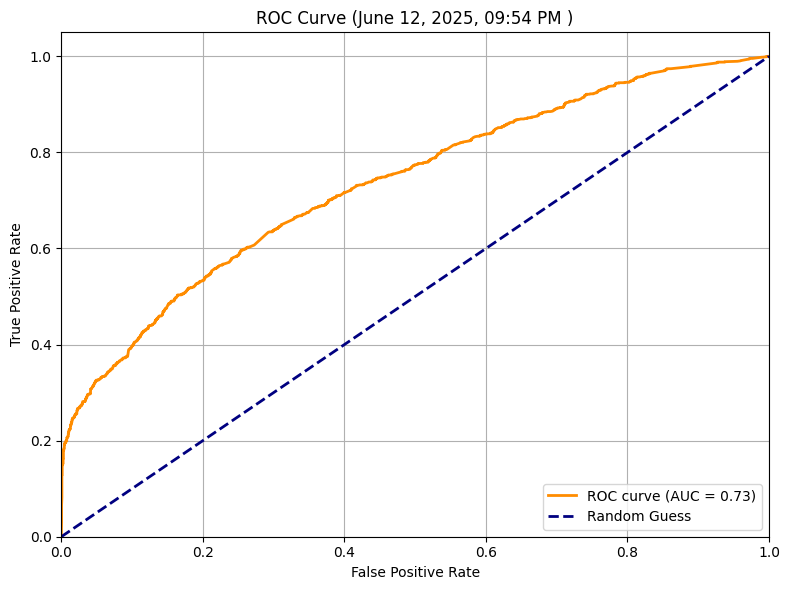

In [15]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y.iloc[test_idx], pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# G-Mean
cm_adjusted = confusion_matrix(y.iloc[test_idx], pred_adjusted)
recall_0 = cm_adjusted[0, 0] / (cm_adjusted[0, 0] + cm_adjusted[0, 1])
recall_1 = cm_adjusted[1, 1] / (cm_adjusted[1, 0] + cm_adjusted[1, 1])
gmean = np.sqrt(recall_0 * recall_1)
print(f"\nG-Mean (Adjusted Threshold): {gmean:.4f}")
print(f"Recall Class 0 (Specificity): {recall_0:.4f}")
print(f"Recall Class 1 (Sensitivity): {recall_1:.4f}")


G-Mean (Adjusted Threshold): 0.6670
Recall Class 0 (Specificity): 0.7463
Recall Class 1 (Sensitivity): 0.5961



Confusion Matrix (Adjusted Threshold):
[[1733  589]
 [ 471  695]]


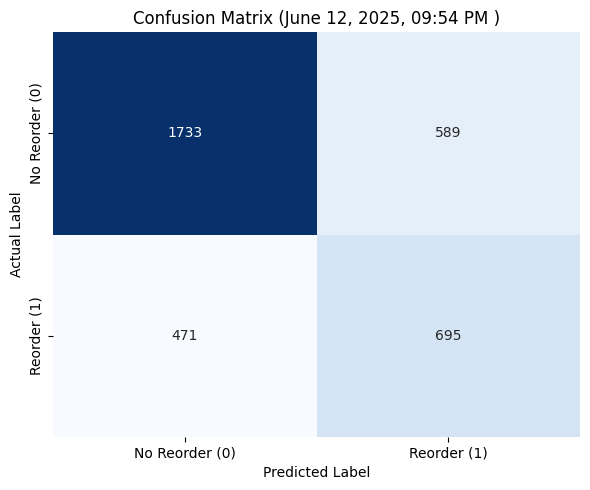

In [17]:
# Confusion Matrix
print("\nConfusion Matrix (Adjusted Threshold):")
print(cm_adjusted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Reorder (0)', 'Reorder (1)'],
            yticklabels=['No Reorder (0)', 'Reorder (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title(f'Confusion Matrix ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
plt.tight_layout()
plt.show()

### KDE Plot

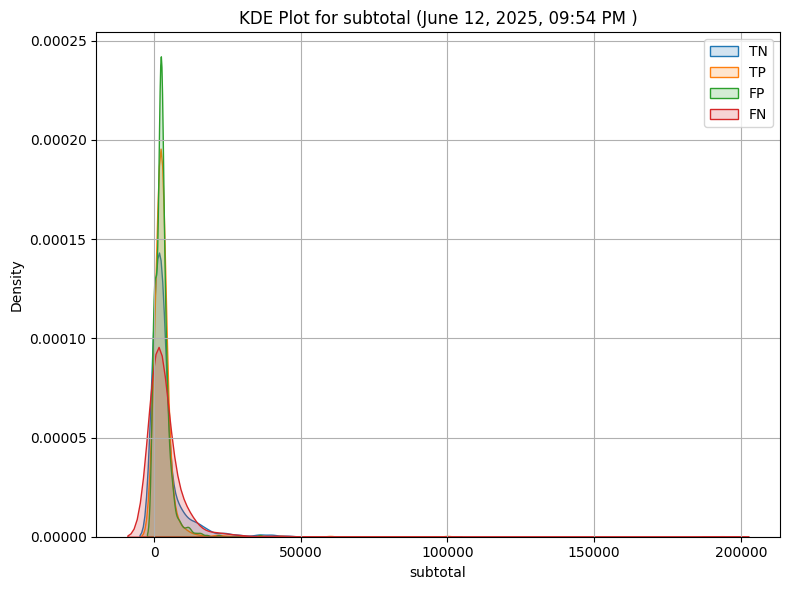

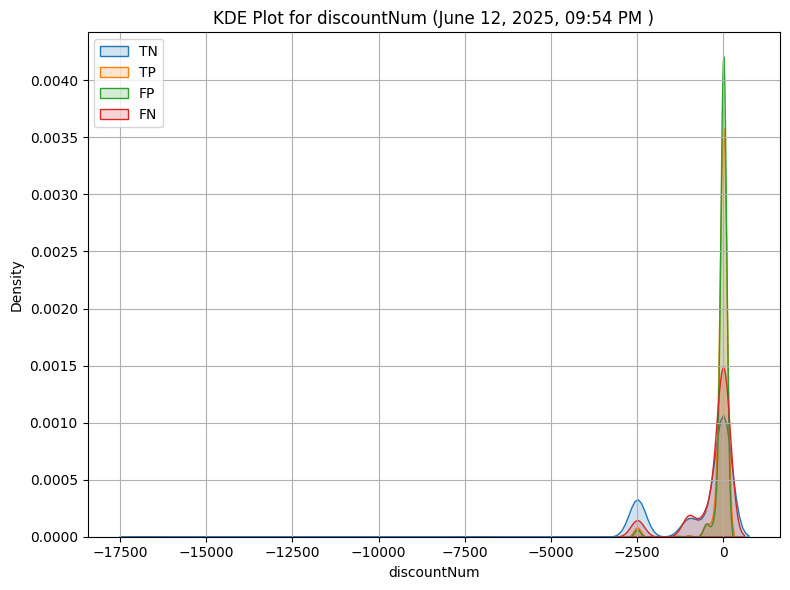

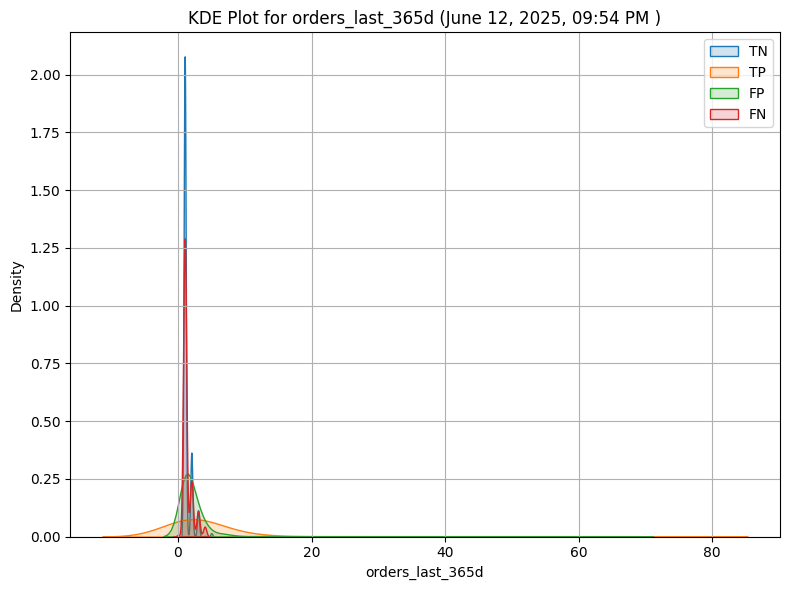

In [18]:
# KDE Plots for Numerical Features
test_df = X.iloc[test_idx].copy()
test_df['actual'] = y.iloc[test_idx]
test_df['predicted'] = pred_adjusted

# Define TP, TN, FP, FN
test_df['category'] = 'Unknown'
test_df.loc[(test_df['actual'] == 0) & (test_df['predicted'] == 0), 'category'] = 'TN'
test_df.loc[(test_df['actual'] == 1) & (test_df['predicted'] == 1), 'category'] = 'TP'
test_df.loc[(test_df['actual'] == 0) & (test_df['predicted'] == 1), 'category'] = 'FP'
test_df.loc[(test_df['actual'] == 1) & (test_df['predicted'] == 0), 'category'] = 'FN'

for col in num_cols:
    plt.figure(figsize=(8, 6))
    for category in ['TN', 'TP', 'FP', 'FN']:
        subset = test_df[test_df['category'] == category]
        if len(subset) > 0:  # Only plot if category has data
            sns.kdeplot(data=subset, x=col, label=category, fill=True, alpha=0.2)
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.title(f'KDE Plot for {col} ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Proportion Bar Plots

<Figure size 1000x600 with 0 Axes>

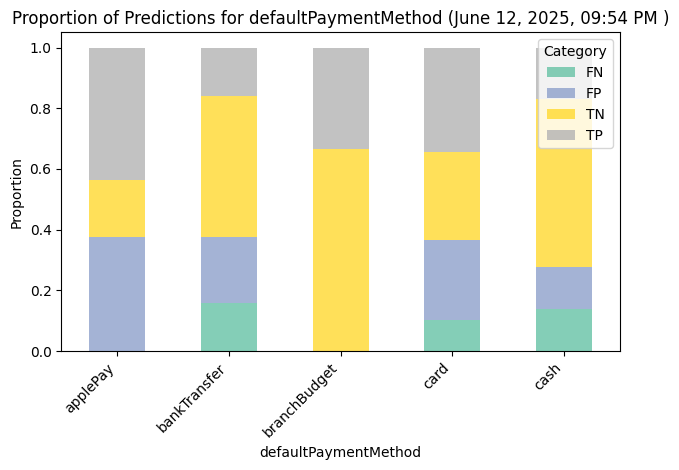

C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 37912 (\N{CJK UNIFIED IDEOGRAPH-9418}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 40670 (\N{CJK UNIFIED IDEOGRAPH-9EDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 28165 (\N{CJK 

<Figure size 1000x600 with 0 Axes>

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37912 (\N{CJK UNIFIED IDEOGRAPH-9418}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-

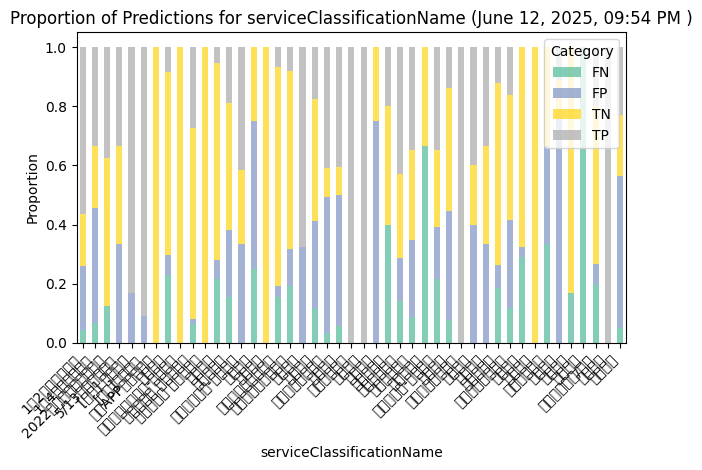

<Figure size 1000x600 with 0 Axes>

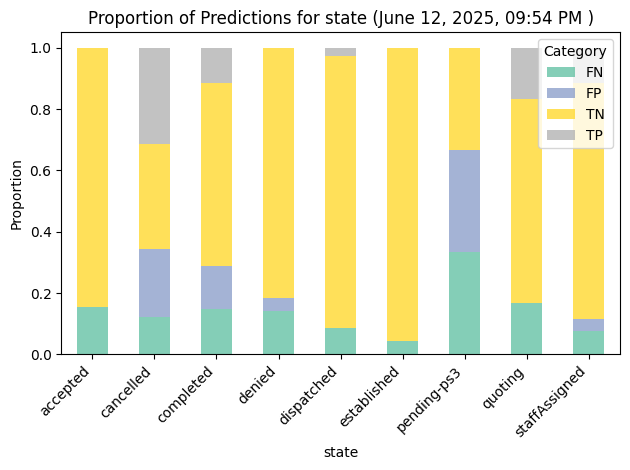

C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 32681 (\N{CJK UNIFIED IDEOGRAPH-7FA9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10264\2253767672.py:15: UserWarning: Glyph 24066 (\N{CJK 

<Figure size 1000x600 with 0 Axes>

c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25237 (\N{CJK UNIFIED IDEOGRAPH-6295}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32291 (\N{CJK UNIFIED IDEOGRAPH-7E23}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22025 (\N{CJK UNIFIED IDEOGRAPH-5609}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\OneDrive\Documents\DSC_Project\.venv\Lib\site-

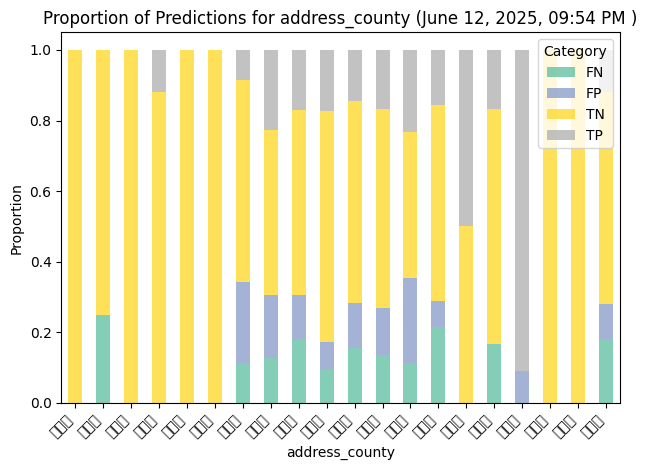

<Figure size 1000x600 with 0 Axes>

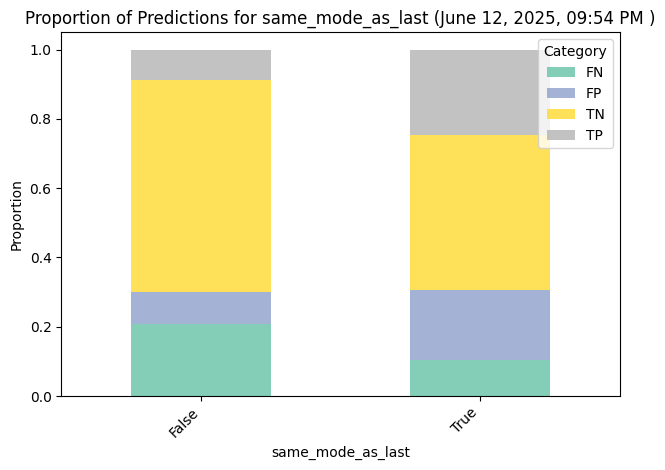

<Figure size 1000x600 with 0 Axes>

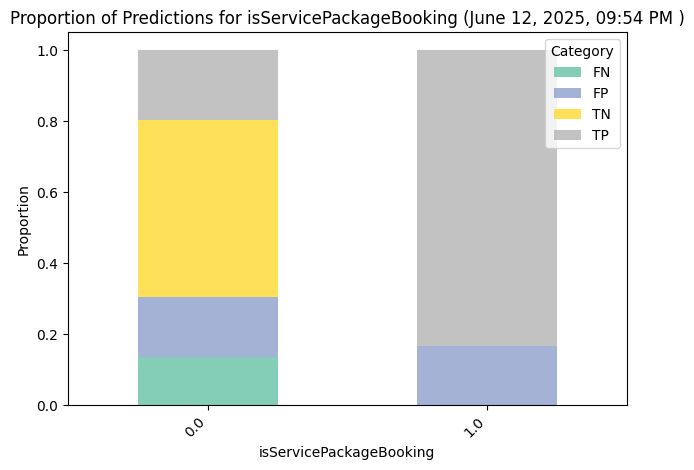

<Figure size 1000x600 with 0 Axes>

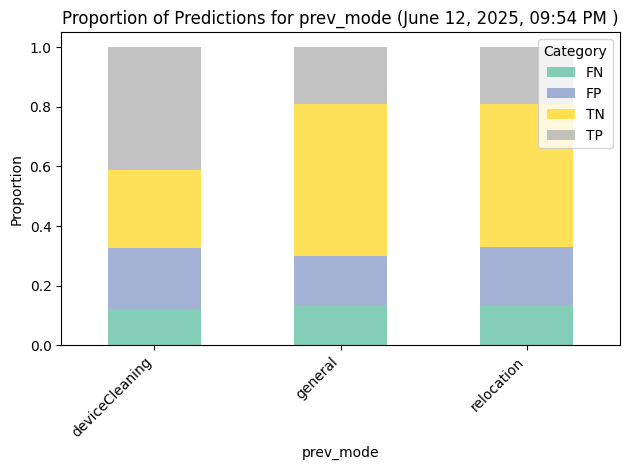

In [19]:
for col in cat_cols:
    # Compute counts for each category and prediction outcome
    counts = test_df.groupby([col, 'category']).size().unstack(fill_value=0)
    # Normalize to proportions
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar plot
    plt.figure(figsize=(10, 6))
    proportions.plot(kind='bar', stacked=True, colormap='Set2', alpha=0.8)
    plt.xlabel(col)
    plt.ylabel('Proportion')
    plt.title(f'Proportion of Predictions for {col} ({datetime.datetime.now().strftime("%B %d, %Y, %I:%M %p %Z")})')
    plt.legend(title='Category', loc='upper right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()